# Enriched flagellins across biomes

This notebook will focus on phylogenetic analyses with differentially abundant (DA) flagellins previously identified between host-associated and free-living environments

### Set-up

In [3]:
library(tidyverse)
library(ggplot2)
library(ggsci)
library(viridis)
library(conflicted)
library(gridExtra)
library(vegan)
library(ape)
library(lattice)
library(permute)
library(grid) 
library(seqinr)
library("picante")
library("phylosignal")
library("phytools")
library(rentrez)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.0.9     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.4.1
✔ ggplot2   3.3.6     ✔ tibble    3.2.1
✔ lubridate 1.8.0     ✔ tidyr     1.2.1
✔ purrr     0.3.5     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:seqinr’:

    gls


The following object is masked from ‘p

In [4]:
conflict_prefer("filter","dplyr")
conflict_prefer("rename","dplyr")
conflict_prefer("mutate","dplyr")
conflict_prefer("count","dplyr")

[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::rename over any other package.
[conflicted] Will prefer dplyr::mutate over any other package.
[conflicted] Will prefer dplyr::count over any other package.


### Import input files

## Non-rarefied / filtered results

In [10]:
#EdgeR results
DA.animals.env = read_tsv("seqs/DA.animals.env.tsv",col_names=T)
DA.animals.plants = read_tsv("seqs/DA.animal.plants.tsv",col_names=T)
DA.plants.env = read_tsv("seqs/DA.plants.env.tsv",col_names=T)
DA.host.env = read_tsv("seqs/DA.host.env.tsv",col_names=T)

Rows: 609 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, Domain, Phylum, Class, Order, Family, Genus, Species, En...
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 203 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, Domain, Phylum, Class, Order, Family, Genus, Species, En...
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 326 Columns: 13
── Column specif

In [11]:
#Flagellin multifasta
flagellins.markers.sb=seqinr::read.fasta("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/out.finalmap.faa",seqtype="AA")

In [92]:
flagellin.sizes.taxonomy = read_tsv("../../../flagellin_phylogeny//fla.sb.taxonomy.length.tsv",col_names=T) %>%
select(Accession,length,HVR_length,ncbi_phylum,genome_size)

Rows: 9963 Columns: 13
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, ncbi_phylum, Domain, Phylum, Class, Order, Family, Genus...
dbl (4): length, HVR_length, ncbi_taxid, genome_size

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
#Filter sequences for each set of DA flagellins
seqs.DA.animals.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.env$Accession))]
seqs.DA.animals.plants = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.animals.plants$Accession))]
seqs.DA.plants.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.plants.env$Accession))]
seqs.DA.host.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.host.env$Accession))]

In [14]:
#Export sequences
write.fasta(sequences = seqs.DA.animals.env, names = names(seqs.DA.animals.env), nbchar = 80, file.out = "seqs/seqs.DA.animals.env.faa")
write.fasta(sequences = seqs.DA.animals.plants, names = names(seqs.DA.animals.plants), nbchar = 80, file.out = "seqs/seqs.DA.animals.plants.faa")
write.fasta(sequences = seqs.DA.plants.env, names = names(seqs.DA.plants.env), nbchar = 80, file.out = "seqs/seqs.DA.plants.env.faa")
write.fasta(sequences = seqs.DA.host.env, names = names(seqs.DA.host.env), nbchar = 80, file.out = "seqs/seqs.DA.host.env.faa")


In [89]:
names(DA.animals.env)

[1] "Accession"  "Domain"     "Phylum"     "Class"      "Order"     
 [6] "Family"     "Genus"      "Species"    "logFC"      "logCPM"    
[11] "PValue"     "FDR"        "EnrichedIn"

In [93]:
map.DA.animals.env = inner_join(DA.animals.env,flagellin.sizes.taxonomy,by="Accession")

In [94]:
head(map.DA.animals.env)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,EnrichedIn,length,HVR_length,ncbi_phylum,genome_size
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
EEJ52905.1,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Actinomycetales,f__Actinomycetaceae,g__Mobiluncus,s__Mobiluncus mulieris,3.080322,11.98937,5.780637e-75,1.138786e-71,Environmental,511,271,Actinobacteria,2435166
OUT94870.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Parvibaculales,f__RS24,g__UBA7378,s__UBA7378 sp002689195,3.446868,11.46430,7.556581e-64,7.443232e-61,Environmental,671,431,Proteobacteria,1652246
KQT19785.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Beijerinckiaceae,g__Methylobacterium,s__Methylobacterium sp001423265,2.750747,11.26181,5.330136e-60,3.500123e-57,Environmental,569,329,Proteobacteria,4456718
KDR32911.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Caballeronia,s__Caballeronia zhejiangensis,3.268495,14.43158,1.497735e-52,7.376344e-50,Environmental,426,186,Proteobacteria,7666841
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,2.372564,11.40918,1.161668e-42,4.576974e-40,Environmental,506,266,Proteobacteria,5876049
WP_068024403.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Xanthobacteraceae,g__Z2-YC6860,s__Z2-YC6860 sp001579845,2.629497,11.07332,1.590802e-40,5.223134e-38,Environmental,274,34,Proteobacteria,8193889


In [95]:
#Create mapping files
map.DA.animals.env = inner_join(DA.animals.env,flagellin.sizes.taxonomy,by="Accession")
map.DA.animals.plants = inner_join(DA.animals.plants,flagellin.sizes.taxonomy,by="Accession")
map.DA.plants.env = inner_join(DA.plants.env,flagellin.sizes.taxonomy,by="Accession")
map.DA.host.env = inner_join(DA.host.env,flagellin.sizes.taxonomy,by="Accession")

In [96]:
nrow(map.DA.animals.plants)

[1] 203

In [97]:
#Write mapping files
write_tsv(map.DA.animals.env,"seqs/map.DA.animals.env.tsv")
write_tsv(map.DA.animals.plants,"seqs/map.DA.animals.plants.tsv")
write_tsv(map.DA.plants.env,"seqs/map.DA.plants.env.tsv")
write_tsv(map.DA.host.env,"seqs/map.DA.host.env.tsv")

In [98]:
#Count the number of enriched flagellins per pairwise group-comparison
dplyr::count(map.DA.animals.env,EnrichedIn)
dplyr::count(map.DA.animals.plants,EnrichedIn)
dplyr::count(map.DA.plants.env,EnrichedIn)
dplyr::count(map.DA.host.env,EnrichedIn)

EnrichedIn,n
<chr>,<int>
Animals,122
Environmental,487


EnrichedIn,n
<chr>,<int>
Animals,121
Plants,82


EnrichedIn,n
<chr>,<int>
Environmental,283
Plants,43


EnrichedIn,n
<chr>,<int>
Environmental,513
Host-associated,110


### Subset Proteobacteria from animals/plants comparison

In [99]:
DA.proteo.animals.plants = filter(map.DA.animals.plants,Phylum=="p__Proteobacteria")

In [100]:
nrow(DA.proteo.animals.plants)

[1] 111

In [101]:
seqs.DA.proteo.animals.plants = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% DA.proteo.animals.plants$Accession))]

In [102]:
length(seqs.DA.proteo.animals.plants)

[1] 111

In [103]:
write.fasta(sequences = seqs.DA.proteo.animals.plants, names = names(seqs.DA.proteo.animals.plants), nbchar = 80, file.out = "seqs/seqs.DA.proteo.animals.plants.faa")

In [104]:
map.proteo.animals.plants = filter(map.DA.animals.plants)

## Define the two datasets

In [105]:
DA.animals = filter(map.DA.animals.plants,EnrichedIn=="Animals")
DA.plants = filter(map.DA.animals.plants,EnrichedIn=="Plants")
DA.env = filter(map.DA.host.env,EnrichedIn=="Environmental")
DA.host = filter(map.DA.host.env,EnrichedIn=="Host-associated")

In [106]:
#Write datasets of flagellins enriched in each biome
write_tsv(DA.animals,"DA.animals.tsv")
write_tsv(DA.plants,"DA.plants.tsv")
write_tsv(DA.env,"DA.env.tsv")
write_tsv(DA.host,"DA.host.tsv")

In [107]:
nrow(DA.animals)
nrow(DA.plants)
nrow(DA.env)
nrow(DA.host)

[1] 121

[1] 82

[1] 513

[1] 110

In [36]:
#set.all=read.delim("../flags.tax.nonrareAll.tsv")%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

In [111]:
allFlas = readRDS("../../filter_taxa_All_count_subsampled.median.rds")

In [114]:
#Define the datasets
set.animals=DA.animals
set.plants=DA.plants
set.env=DA.env
set.host=DA.host
set.all=rownames_to_column(as.data.frame(allFlas@tax_table),var="Accession")%>%
    inner_join(flagellin.sizes.taxonomy,by="Accession")

##### Import phylogeny

In [112]:
#Import full set phylogeny

tre.all=allFlas@phy_tree#read.tree("flags.nonrareAll.tre")
phy=midpoint.root(tre.all)
tre.all


Phylogenetic tree with 1971 tips and 1970 internal nodes.

Tip labels:
  WP_018305791.1, KJS48310.1, EHQ91627.1, KRE97958.1, WP_039230967.1, ESU34160.1, ...
Node labels:
  0.881, 0.842, 0.893, 0.836, 0.585, 0.807, ...

Rooted; includes branch lengths.

##### Create traits dataframe

In [115]:
#Create traits dataframe
traits.enriched= set.all %>% 
    mutate(enriched.animals=if_else(tre.all$tip.label%in%set.animals$Accession,1,0))%>%
    mutate(enriched.plants=if_else(tre.all$tip.label%in%set.plants$Accession,1,0))%>%
    mutate(enriched.env=if_else(tre.all$tip.label%in%set.env$Accession,1,0))%>%
    mutate(enriched.host=if_else(tre.all$tip.label%in%set.host$Accession,1,0))%>%
    select(Accession,enriched.animals,enriched.plants,enriched.env,enriched.host,length,genome_size)

head(traits.enriched)

,Accession,enriched.animals,enriched.plants,enriched.env,enriched.host,length,genome_size
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WP_018305791.1,0,0,1,0,382,5666696
2,KJS48310.1,0,0,1,0,1153,6027195
3,EHQ91627.1,0,0,0,0,843,5660978
4,KRE97958.1,0,0,0,0,555,8257780
5,WP_039230967.1,0,0,1,0,478,3825819
6,ESU34160.1,0,0,0,0,455,4696869


##### Create trait list for phylosignal object

In [119]:
#Create trait list for phylosignal object
dat <- list()
dat$enriched.animals <- traits.enriched$enriched.animals
dat$enriched.plants <- traits.enriched$enriched.plants
dat$enriched.env <- traits.enriched$enriched.env
dat$enriched.host <- traits.enriched$enriched.host
dat$SeqLength <- traits.enriched$length
dat$genome_size <- traits.enriched$genome_size
dat <- as.data.frame(dat)
rownames(dat) = traits.enriched$Accession
head(dat)

,enriched.animals,enriched.plants,enriched.env,enriched.host,SeqLength,genome_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_018305791.1,0,0,1,0,382,5666696
KJS48310.1,0,0,1,0,1153,6027195
EHQ91627.1,0,0,0,0,843,5660978
KRE97958.1,0,0,0,0,555,8257780
WP_039230967.1,0,0,1,0,478,3825819
ESU34160.1,0,0,0,0,455,4696869


In [120]:
nrow(dat)

[1] 1971

##### Create phylosignal object

In [121]:
#Create phylosignal object
p4d <- phylobase::phylo4d(phy, dat)

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


##### Testing phylosignal

In [122]:
#Test phylosignal hypothesis using Pagel's Lambda method for categorical traits
phylosignal.finalset=phyloSignal(p4d,methods=c("Lambda","Cmean"))
phylosignal.finalset

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


,Cmean,Lambda
,<dbl>,<dbl>
enriched.animals,0.3083298,0.3212758
enriched.plants,0.2880813,0.4847696
enriched.env,0.1330837,0.3355527
enriched.host,0.3110734,0.2896148
SeqLength,0.6026298,1.1370786
genome_size,0.5985572,0.9483802
,Cmean,Lambda
,<dbl>,<dbl>
enriched.animals,0.001,0.001


In [123]:
flag.lipa <- lipaMoran(p4d)

Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in .local(x, ...):
“Non-unique or missing labels found, labels cannot be coerced to tdata row.names. Use the label.type argument to include labels as first column of data.”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”
Warning message in checkTree(object):
“Labels are not unique. ”


In [124]:
#barplot.phylo4d(flag.lipa.p4d, trait = "seqLength",bar.col=(flag.lipa$p.value < 0.05) + 1, center = FALSE , scale = FALSE,label.type=T)

In [125]:
host.env.dat = map.DA.host.env %>% 
select(Accession,HVR_length,genome_size)
rownames(host.env.dat) = host.env.dat$Accession
head(host.env.dat)

Warning message:
“Setting row names on a tibble is deprecated.”


Accession,HVR_length,genome_size
<chr>,<dbl>,<dbl>
OUT94870.1,431,1652246
EEJ52905.1,271,2435166
KDR32911.1,186,7666841
KQT19785.1,329,4456718
OQW31935.1,35,3659024
ORC34218.1,42,4216685


In [126]:
#phy.host.env = prune.sample(,phy)
#prunedphy <- prune.sample(comm, phy)
#p4d <- phylobase::phylo4d(phy, dat)

In [127]:
#comm

### Using SES of MPD (Mean Pairwise Distance) and MNTD (Mean Nearest Taxon Distance) implemented in Picante

##### Phylogeny

In [128]:
phy


Phylogenetic tree with 1971 tips and 1970 internal nodes.

Tip labels:
  OEU73186.1, WP_018305791.1, KJS48310.1, EHQ91627.1, KRE97958.1, WP_039230967.1, ...
Node labels:
  Root, 0.713, 0.411, 0.569, 0.945, 0.449, ...

Rooted; includes branch lengths.

##### Community data

In [129]:
all.flas=rep(1,nrow(traits.enriched))
enriched.plants =rep(if_else(traits.enriched$enriched.plants==1,1,0))
enriched.env =rep(if_else(traits.enriched$enriched.env==1,1,0))
enriched.host = rep(if_else(traits.enriched$enriched.host==1,1,0))


comm.data=traits.enriched %>%
  select(Accession,enriched.animals)%>%
  mutate(Sample="enriched.animals")%>%
  distinct(Accession,.keep_all=T)%>%
  spread(Accession,enriched.animals)%>%
  column_to_rownames(var= "Sample")%>%
  rbind(enriched.plants)%>%
  rbind(enriched.env)%>%
  rbind(enriched.host)
  
row.names(comm.data) <- c("enriched.animals","enriched.plants","enriched.env","enriched.host")

comm=as.matrix(comm.data[1:nrow(comm.data),2:ncol(comm.data)])

comm.data

,AAA62844.1,AAG14365.1,AAG34566.1,AAK24938.1,AAP77961.1,AAR10646.1,AAR10729.1,AAT06254.1,AAW75835.1,AAZ64437.1,⋯,WP_118137284.1,WP_118178391.1,WP_118183865.1,WP_118202691.1,WP_118280384.1,WP_118508201.1,WP_118558985.1,WP_118680381.1,WP_118680383.1,WP_118710912.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
enriched.plants,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
enriched.env,1,1,0,0,1,0,0,0,0,0,⋯,1,0,1,0,0,0,0,0,0,0
enriched.host,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0


##### Trait data

In [130]:
traits= dat
head(traits)

,enriched.animals,enriched.plants,enriched.env,enriched.host,SeqLength,genome_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_018305791.1,0,0,1,0,382,5666696
KJS48310.1,0,0,1,0,1153,6027195
EHQ91627.1,0,0,0,0,843,5660978
KRE97958.1,0,0,0,0,555,8257780
WP_039230967.1,0,0,1,0,478,3825819
ESU34160.1,0,0,0,0,455,4696869


##### Root phylogeny by midpoint

In [131]:
prunedphy <- prune.sample(comm, phy)
rooted.prunedphy=midpoint.root(prunedphy)

##### Plot distribution of selected taxa in each dataset across the phylogeny of top abundant (n=1263)

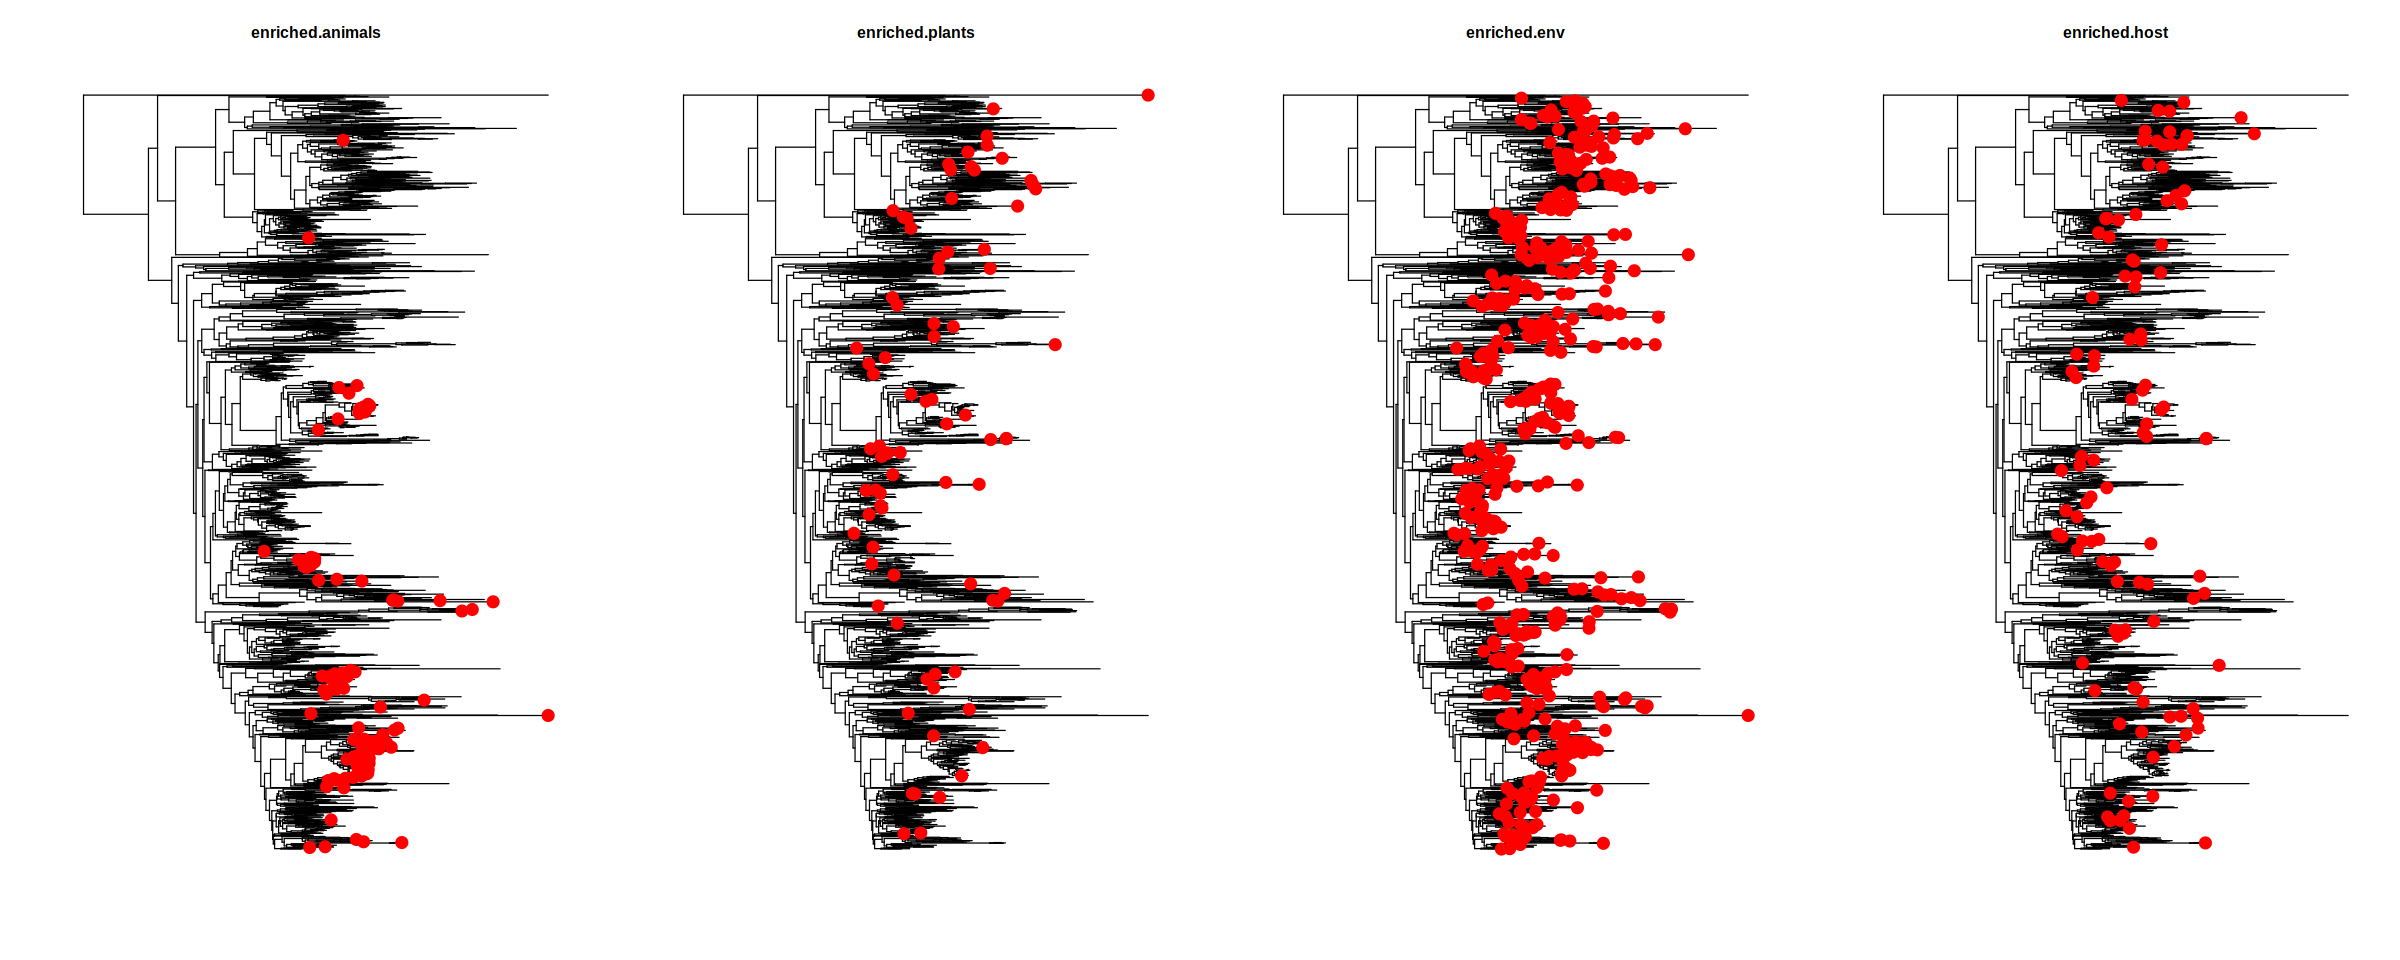

In [132]:
options(repr.plot.width=20,repr.plot.height=8)
par(mfrow = c(1, 4))
for (i in row.names(comm)) {plot(phy, show.tip.label = FALSE, main = i)
  tiplabels(tip = which(phy$tip.label %in% names(which(comm [i, ] > 0))),
pch=19, cex=2,col="red")
}

##### Calculate phylogenetic diversity

In [133]:
#pd
phy.div=pd(comm,phy,include.root=TRUE)
phy.div

,PD,SR
,<dbl>,<dbl>
enriched.animals,37.94618,121
enriched.plants,48.29071,82
enriched.env,196.43300,512
enriched.host,59.56974,110


##### Calculate null models of community assembly

In [134]:
#Create phylogeny distance matrix (MDP and MNTD require a matrix as input)
phydist=cophenetic.phylo(phy)
#phydist

#Using MDP measure (MEAN PAIRWISE DISTANCE)
ses.mpd.result <- ses.mpd(comm, phydist, null.model="taxa.labels", abundance.weighted=FALSE, runs=1000)



#Using standardized effect size of phylogenetic diversity (Faith's PD)
ses.pd <- ses.pd(samp = comm, 
                        tree = phy, 
                        null.model = "taxa.labels", 
                        runs = 1000)


#Using MNTD measure (MEAN NEAREST TAXON DISTANCE)
ses.mntd.result <- ses.mntd(comm, phydist, null.model="taxa.labels",abundance.weighted=FALSE, runs=1000)


In [135]:
ses.mpd.result
ses.pd
ses.mntd.result

,ntaxa,mpd.obs,mpd.rand.mean,mpd.rand.sd,mpd.obs.rank,mpd.obs.z,mpd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,121,1.782301,2.186248,0.07568774,1,-5.3370148,0.000999001,1000
enriched.plants,82,2.235903,2.190107,0.08769159,695,0.5222372,0.694305694,1000
enriched.env,512,2.251793,2.190912,0.03034711,987,2.0061417,0.986013986,1000
enriched.host,110,2.205472,2.189350,0.07820766,583,0.2061343,0.582417582,1000


,ntaxa,pd.obs,pd.rand.mean,pd.rand.sd,pd.obs.rank,pd.obs.z,pd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,121,37.94618,65.98137,3.198432,1,-8.7652905,0.000999001,1000
enriched.plants,82,48.29071,49.03778,2.730655,401,-0.2735881,0.400599401,1000
enriched.env,512,196.43300,192.60399,4.766722,784,0.8032797,0.783216783,1000
enriched.host,110,59.56974,61.47170,3.084485,274,-0.6166208,0.273726274,1000


,ntaxa,mntd.obs,mntd.rand.mean,mntd.rand.sd,mntd.obs.rank,mntd.obs.z,mntd.obs.p,runs
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
enriched.animals,121,0.3751027,0.7394592,0.04468047,1,-8.1547155,0.000999001,1000
enriched.plants,82,0.7542808,0.8144185,0.05861131,154,-1.0260419,0.153846154,1000
enriched.env,512,0.4986674,0.4958874,0.01576598,590,0.1763262,0.589410589,1000
enriched.host,110,0.7017282,0.7565728,0.04793129,123,-1.1442349,0.122877123,1000


In [141]:
df.comm.assembly = data.frame(biome = c("Animals","Plants","Free-living"),
                             mpd = c(1.782301,2.235903,2.251793),
                             pd = c(37.94618,48.29071,196.43300),
                             mntd = c(0.3751027,0.7542808,0.4986674))

In [137]:
library(reshape2)
library(ggplot2)
library(ggsci)

In [142]:
df.comm.plot = melt(df.comm.assembly)

Using biome as id variables



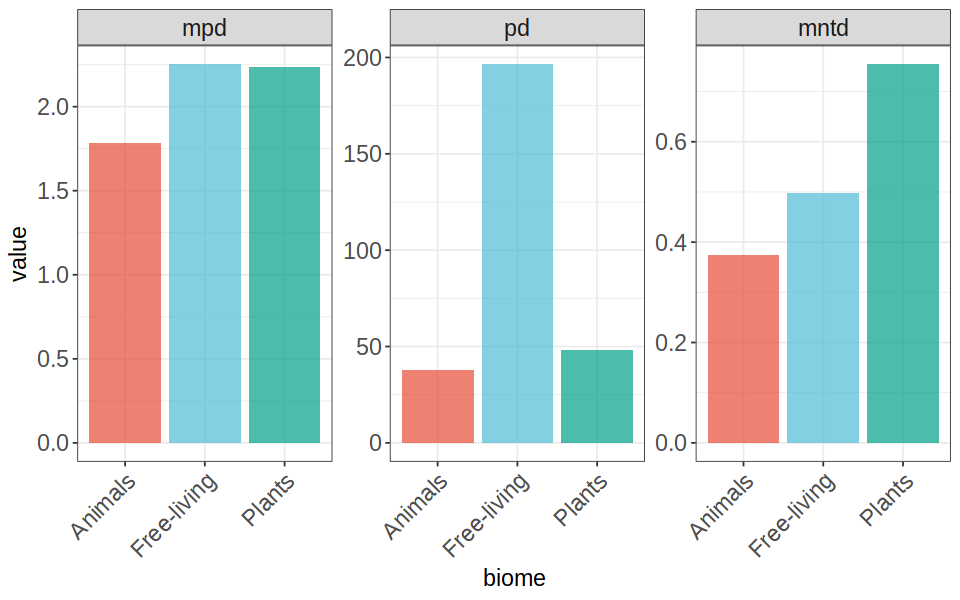

In [143]:
options(repr.plot.width=8,repr.plot.height=5)
ggplot(data=df.comm.plot,aes(x=biome,y=value,fill=biome))+
geom_bar(stat="identity",position = "dodge",alpha=0.7)+
facet_wrap(~variable,scales = "free")+
scale_fill_npg()+
theme_bw()+
theme(axis.title.x = element_text(size=14),
     axis.title.y = element_text(size=14),
     axis.text = element_text(size=14),
      axis.text.x = element_text(size=14,angle=45,hjust=1),
     strip.text.x = element_text(size=14),
     legend.position="none")


## Vertebrates samples

In [140]:
metadataAll = read_tsv("mappingMetadataAll.txt",col_names=T)%>%
filter(category=="Animal")

ERROR: Error: 'mappingMetadataAll.txt' does not exist in current working directory ('/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/shortbred/edgeR/subsampled_opt1').
